<a href="https://colab.research.google.com/github/sfekih/2020/blob/master/projet_final_iapr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')
PROJECT_PATH = os.path.join('drive', 'My Drive', 'Colab Notebooks', 'iapr', 'train_games')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir(PROJECT_PATH)
!pwd

/content/drive/My Drive/Colab Notebooks/iapr/train_games


In [4]:
ls

game1/  game2/  game3/  game4/  game5/  game6/  game7/


In [5]:
cd 'game1'

/content/drive/My Drive/Colab Notebooks/iapr/train_games/game1


In [6]:
ls

10.jpg  12.jpg  1.jpg  3.jpg  5.jpg  7.jpg  9.jpg      green.png
11.jpg  13.jpg  2.jpg  4.jpg  6.jpg  8.jpg  game1.csv  image.png


In [7]:
import pandas as pd
import numpy as np

from PIL import Image
from scipy.spatial import distance_matrix


In [8]:
data_game_1 = pd.read_csv('game1.csv')

In [9]:
def separate_columns(row) :
  row['P1_suit'] = row.P1[1]
  row['P1_digit'] = row.P1[0]
  row['P2_suit'] = row.P2[1]
  row['P2_digit'] = row.P2[0]
  row['P3_suit'] = row.P3[1]
  row['P3_digit'] = row.P3[0]
  row['P4_digit'] = row.P4[1]
  row['P4_suit'] = row.P4[0]
  return row
data_game_preprocessed = data_game_1.apply(lambda x: separate_columns(x), axis=1)\
                                    .drop(columns={'P1', 'P2', 'P3', 'P4'})\
                                    .rename(columns={'Unnamed: 0':'round_nb'})
data_game_preprocessed

,round_nb,D,P1_suit,P1_digit,P2_suit,P2_digit,P3_suit,P3_digit,P4_digit,P4_suit
0,1,1,S,Q,H,8,H,J,S,0
1,2,1,S,5,S,J,C,9,D,K
2,3,1,D,1,H,3,C,7,D,3
3,4,1,S,1,D,J,S,4,C,4
4,5,1,D,0,S,6,C,3,C,2
5,6,1,S,8,D,9,S,3,S,K
6,7,1,D,4,H,7,D,7,H,6
7,8,1,C,0,C,K,S,9,C,8
8,9,1,D,5,H,5,H,1,S,7
9,10,1,H,Q,C,Q,D,6,H,9


In [10]:
#pip install Pillow
from PIL import Image
# Open the image form working directory
image = Image.open('1.jpg')

In [11]:
data = np.asarray(image)
data.shape 

(4608, 3456, 3)

In [12]:
import cv2
import matplotlib.pyplot as plt


In [13]:
#read as BGR
img = cv2.imread("1.jpg")


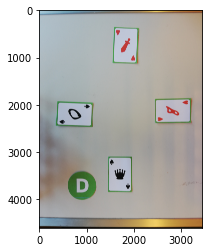

In [14]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [15]:

## convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

## mask of green (36,25,25) ~ (86, 255,255)
# mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
mask = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))

## slice the green
imask = mask>0
green = np.zeros_like(img, np.uint8)
green[imask] = 255


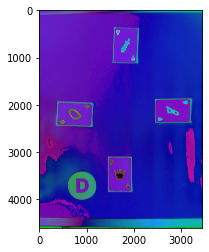

In [16]:
plt.imshow(hsv)

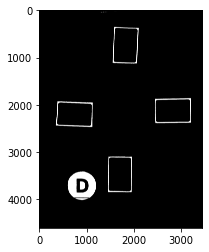

In [17]:
import matplotlib.pyplot as plt
plt.imshow(green)

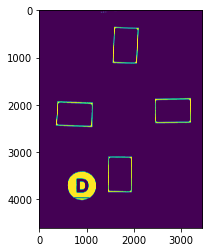

In [18]:
greyscale = cv2.cvtColor(green, cv2.COLOR_BGR2GRAY)
plt.imshow(greyscale)

In [19]:
contours, _ = cv2.findContours(greyscale, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [20]:
cntsSorted = sorted(contours, key=lambda x: cv2.contourArea(x))[::-1][:5]

In [21]:
#cntsSorted[3]

In [22]:
#[cv2.contourArea(contour) for contour in contours]

In [23]:
cimg = np.zeros_like(greyscale)
cimg_copy = cimg
centers = np.zeros((5, 2))
for i in range (5):    
  M = cv2.moments(cntsSorted[i])
  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])
  centers[i, 0] = cX
  centers[i, 1] = cY

In [24]:
centers_cards = centers[:-1,:]
center_badge = centers[-1,:]
player1 = np.argmax(centers_cards[:,1])
player3 = np.argmin(centers_cards[:,1])
player2 = np.argmin(centers_cards[:,0])
player4 = np.argmax(centers_cards[:,0])
players_args = [player1, player2, player3, player4]
centers_ordered = np.array([centers_cards[i,:] for i in players_args])

In [25]:
#cntsSorted[3]
#players_args

In [26]:
ordered_contours_cards = [cntsSorted[i] for i in players_args]

In [27]:
cards_only = cv2.drawContours(cimg.copy(), ordered_contours_cards.copy(), -1, color=255, thickness=-1)
cards_and_badge = cv2.drawContours(cimg.copy(), ordered_contours_cards.copy(), -1, color=255, thickness=-1)

cimg_2 = cv2.drawContours(cimg.copy(), cntsSorted, -1, color=255, thickness=-1)

In [28]:
#ordered_contours_cards[0]

In [29]:
centers_distances = np.array([np.linalg.norm(centers_ordered[i, :]-center_badge) for i in range (4)])
badge_idx = np.argmin(centers_distances)
print ('player who has badge is :', badge_idx + 1)

player who has badge is : 1


In [30]:
cards_only.shape

(4608, 3456)

In [31]:
digits = []
suits = []
for iter in range (0, 4) :
  cimg_copy = np.zeros((img.shape[0], img.shape[1]))

  one_card = cv2.drawContours(cimg_copy.copy(), ordered_contours_cards.copy(), iter, color=255, thickness=-1)

  mask_cards_only = one_card < 1
  img_cards_only = img.copy()
  img_cards_only[mask_cards_only, : ] = 0

  greyscale_one_card = cv2.cvtColor(img_cards_only.copy(), cv2.COLOR_BGR2GRAY)

  _,img_cards_only_copy = cv2.threshold(greyscale_one_card.copy(),150,255,cv2.THRESH_BINARY)

  img_cards_only_copy = np.rot90(img_cards_only_copy, k=iter)




  contours_card, _ = cv2.findContours(img_cards_only_copy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  contours_card = [contour for contour in contours_card if cv2.contourArea(contour)>100]
  #cntsSorted = sorted(contours, key=lambda x: cv2.contourArea(x))[::-1][1:]




  def find_suits (contours_card) :
  centers = np.zeros((len(contours_card), 2))
  for i in range (0, len(contours_card)):
    M = cv2.moments(contours_card[i])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centers[i, 0] = cX
    centers[i, 1] = cY

  distances = distance_matrix(centers, centers)
  (suit1, val), suit2 = max(map(lambda x: (max(enumerate(x[1]), key= lambda x: x[1]), x[0]), enumerate(distances)), key=lambda x: x[0][1])




  sign_contour = contours_card[0]
  final_contours = [contours_card[i] for i in range (0, len(contours_card)) if i!=suit1 and i!=suit2]
  min_x = np.min(final_contours[0][:,0,0])
  min_y = np.min(final_contours[0][:,0,1])

  for i in range (len(final_contours)) :
    final_contours[i][:,0,0] = final_contours[i][:,0,0] - min_x + 1
    final_contours[i][:,0,1] = final_contours[i][:,0,1] - min_y + 1

  img_cards_only_copy = np.zeros((500, 500))
  digit = cv2.drawContours(img_cards_only_copy, final_contours, -1, color=255, thickness=-1)
  digits.append(digit)





  suits_contours = [contours_card[j] for j in range (0, len(contours_card)) if j==suit1 or j==suit2]
  idx = np.argmax([suits_contours[0][:, 0, 1].max(), suits_contours[1][:, 0, 1].max()])
  color_contour = contours_card[idx]

  min_x = np.min(color_contour[:,0,0])
  min_y = np.min(color_contour[:,0,1])

  color_contour[:,0,0] = color_contour[:,0,0] - min_x + 1
  color_contour[:,0,1] = color_contour[:,0,1] - min_y + 1

  img_cards_only_copy = np.zeros((200, 200))
  cards_only = cv2.drawContours(img_cards_only_copy, [color_contour], -1, color=255, thickness=-1)
  suits.append(cards_only)

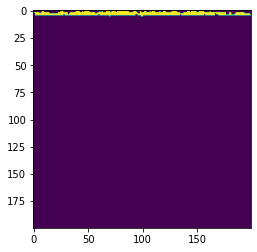

In [32]:
plt.imshow(suits[0])

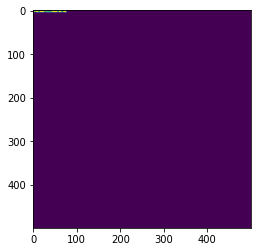

In [33]:
plt.imshow(digits[0])

In [34]:
assert(1==2)

AssertionError: ignored

TypeError: ignored

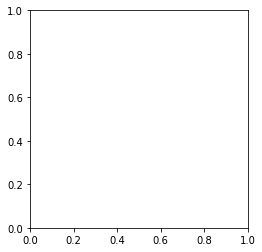

In [37]:
plt.imshow(contours_card[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(7,)

In [ ]:
contours, _ = cv2.findContours(img_cards_only_copy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = [contour for contour in contours if cv2.contourArea(contour)>100]
cntsSorted = sorted(contours, key=lambda x: cv2.contourArea(x))[::-1][1:]





centers = np.zeros((len(cntsSorted), 2))
for i in range (len(cntsSorted)):
  M = cv2.moments(cntsSorted[i])
  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])
  centers[i, 0] = cX
  centers[i, 1] = cY

distances = distance_matrix(centers, centers)
(suit1, val), suit2 = max(map(lambda x: (max(enumerate(x[1]), key= lambda x: x[1]), x[0]), enumerate(distances)), key=lambda x: x[0][1])




sign_contour = cntsSorted[0]
final_contours = [cntsSorted[i] for i in range (len(cntsSorted)) if i!=suit1 and i!=suit2]
min_x = np.min(final_contours[0][:,0,0])
min_y = np.min(final_contours[0][:,0,1])

for i in range (len(final_contours)) :
  final_contours[i][:,0,0] = final_contours[i][:,0,0] - min_x + 1
  final_contours[i][:,0,1] = final_contours[i][:,0,1] - min_y + 1

img_cards_only_copy = np.zeros((500, 500))
cards_only = cv2.drawContours(img_cards_only_copy, final_contours, -1, color=255, thickness=-1)
plt.imshow(img_cards_only_copy)






suits_contours = [cntsSorted[i] for i in range (len(cntsSorted)) if i==suit1 or i==suit2]
idx = np.argmax([suits_contours[0][:, 0, 1].max(), suits_contours[1][:, 0, 1].max()])
color_contour = cntsSorted[idx]

min_x = np.min(color_contour[:,0,0])
min_y = np.min(color_contour[:,0,1])

color_contour[:,0,0] = color_contour[:,0,0] - min_x + 1
color_contour[:,0,1] = color_contour[:,0,1] - min_y + 1

img_cards_only_copy = np.zeros((200, 200))
cards_only = cv2.drawContours(img_cards_only_copy, [color_contour], -1, color=255, thickness=-1)
plt.imshow(img_cards_only_copy)

In [ ]:
final_contours = np.delete(cntsSorted, row, 0)
final_contours = np.delete(final_contours, col, 0)
len(final_contours)

In [ ]:
sign_contour = cntsSorted[0]
final_contours = [cntsSorted[i] for i in range (len(cntsSorted)) if i!=suit1 and i!=suit2]
min_x = np.min(final_contours[0][:,0,0])
min_y = np.min(final_contours[0][:,0,1])

for i in range (len(final_contours)) :
  final_contours[i][:,0,0] = final_contours[i][:,0,0] - min_x + 1
  final_contours[i][:,0,1] = final_contours[i][:,0,1] - min_y + 1

img_cards_only_copy = np.zeros((500, 500))
cards_only = cv2.drawContours(img_cards_only_copy, final_contours, -1, color=255, thickness=-1)
plt.imshow(img_cards_only_copy)

suits_contours = [cntsSorted[i] for i in range (len(cntsSorted)) if i==suit1 or i==suit2]
idx = np.argmax([suits_contours[0][:, 0, 1].max(), suits_contours[1][:, 0, 1].max()])
color_contour = cntsSorted[idx]

min_x = np.min(color_contour[:,0,0])
min_y = np.min(color_contour[:,0,1])

color_contour[:,0,0] = color_contour[:,0,0] - min_x + 1
color_contour[:,0,1] = color_contour[:,0,1] - min_y + 1

img_cards_only_copy = np.zeros((200, 200))
cards_only = cv2.drawContours(img_cards_only_copy, [color_contour], -1, color=255, thickness=-1)
plt.imshow(img_cards_only_copy)

In [ ]:
#rotate images depending on player
#put in functions
#iterate